# App-9 : Detection de bords par algorithmes genetiques

**Navigation** : [<< App-8 MiniZinc](App-8-MiniZinc.ipynb) | [Index](../README.md) | [App-10 Portfolio >>](App-10-Portfolio.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Comprendre** le principe de la detection de bords par filtres de convolution (Sobel, Prewitt, Laplacien)
2. **Encoder** un filtre de convolution comme chromosome pour un algorithme genetique
3. **Implementer** l'evolution de filtres avec PyGAD et DEAP
4. **Comparer** les deux frameworks en termes d'API, convergence et performances
5. **Analyser** la qualite des filtres evolues par rapport aux references classiques

### Prerequis
- Python 3.10+
- [Search-5 : Algorithmes Genetiques](../Foundations/Search-5-GeneticAlgorithms.ipynb) (concepts GA : selection, crossover, mutation, fitness)
- Notions de base en traitement d'image (convolution)

### Duree estimee : 40 minutes

> **Side track** : Voir [App-9b C#](App-9b-EdgeDetection-CSharp.ipynb) pour la version GeneticSharp en .NET.

## 1. Introduction : detection de bords et filtres de convolution

### Pourquoi detecter les bords ?

La **detection de bords** (edge detection) est l'une des operations fondamentales en vision par ordinateur. Elle permet d'extraire les contours des objets dans une image, ce qui est essentiel pour :

| Application | Utilisation des bords |
|-------------|----------------------|
| Segmentation d'image | Delimiter les regions d'interet |
| Reconnaissance d'objets | Extraire des formes caracteristiques |
| Imagerie medicale | Detecter les contours d'organes ou de tumeurs |
| Conduite autonome | Identifier les voies, panneaux et obstacles |
| OCR | Isoler les caracteres du fond |

### Filtres de convolution classiques

Un **filtre de convolution** (ou noyau) est une petite matrice de coefficients que l'on fait glisser sur l'image. A chaque position, on calcule la somme ponderee des pixels voisins :

$$G(x,y) = \sum_{i=-k}^{k} \sum_{j=-k}^{k} K(i,j) \cdot I(x+i, y+j)$$

ou $K$ est le noyau de taille $(2k+1) \times (2k+1)$ et $I$ est l'image.

Les filtres classiques de detection de bords sont :

| Filtre | Noyau (direction X) | Propriete |
|--------|--------------------|-----------|
| **Sobel** | $\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$ | Gradient avec lissage gaussien |
| **Prewitt** | $\begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}$ | Gradient simple |
| **Laplacien** | $\begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}$ | Derivee seconde (isotrope) |

### Peut-on *apprendre* un filtre automatiquement ?

Plutot que de concevoir manuellement ces filtres, nous allons utiliser un **algorithme genetique** pour faire evoluer automatiquement les coefficients d'un noyau de convolution. L'objectif : approximer le filtre de Sobel a partir de zero, en ne connaissant que le resultat attendu.

Cette approche illustre un concept fondamental de l'optimisation : la capacite a decouvrir des solutions dans un espace de recherche vaste ($[-20, 20]^{49}$ pour un noyau 7x7) sans connaissance *a priori* de la structure de la solution.

## 2. Configuration et filtre de reference

Nous allons d'abord preparer notre environnement :
1. Installer les dependances
2. Creer une image synthetique avec des bords bien definis
3. Appliquer le filtre de Sobel comme reference

In [1]:
%pip install pygad deap scipy matplotlib numpy -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports et configuration

Chargeons les bibliotheques necessaires : `numpy` et `matplotlib` pour le calcul et la visualisation, `scipy.signal` pour la convolution 2D, `pygad` et `deap` pour les algorithmes genetiques.

In [2]:
import sys
sys.path.insert(0, '..')
from search_helpers import *

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import sobel as scipy_sobel
import time

# Mode batch pour execution non-interactive (Papermill/MCP)
import os
BATCH_MODE = os.getenv("BATCH_MODE", "false").lower() in ("true", "1", "yes")
if BATCH_MODE:
    plt.ioff()

# Reproductibilite
np.random.seed(42)

print("Environnement pret.")

Environnement pret.


### Image synthetique de test

Nous creons une image en niveaux de gris contenant des formes geometriques simples (rectangles, cercle, diagonales) pour fournir des bords bien definis. L'avantage d'une image synthetique est le controle total sur la complexite des contours.

In [3]:
def create_synthetic_image(size=128):
    """Create a synthetic grayscale image with clear geometric edges."""
    img = np.zeros((size, size), dtype=np.float64)
    
    # White rectangle
    img[20:50, 20:60] = 200
    
    # Gray rectangle
    img[60:100, 50:110] = 150
    
    # Circle
    center_y, center_x = 40, 90
    radius = 20
    yy, xx = np.ogrid[:size, :size]
    mask = (xx - center_x)**2 + (yy - center_y)**2 <= radius**2
    img[mask] = 255
    
    # Diagonal line (thick)
    for offset in range(-2, 3):
        for i in range(10, 60):
            j = i + 50 + offset
            if 0 <= j < size:
                img[i, j] = 180
    
    # Small square
    img[85:100, 10:25] = 230
    
    # Add slight gradient background to make it more interesting
    gradient = np.tile(np.linspace(0, 30, size), (size, 1))
    img = np.clip(img + gradient, 0, 255)
    
    return img


original_image = create_synthetic_image(128)
print(f"Image synthetique : {original_image.shape}, dtype={original_image.dtype}")
print(f"Plage de valeurs : [{original_image.min():.0f}, {original_image.max():.0f}]")

Image synthetique : (128, 128), dtype=float64
Plage de valeurs : [0, 255]


### Application du filtre de Sobel comme reference

Le filtre de Sobel calcule le gradient de l'image dans les directions X et Y. La magnitude du gradient detecte les bords, quelle que soit leur orientation :

$$\text{Sobel}(x,y) = \sqrt{G_x^2 + G_y^2}$$

Nous utilisons `scipy.ndimage.sobel` pour obtenir notre image de reference.

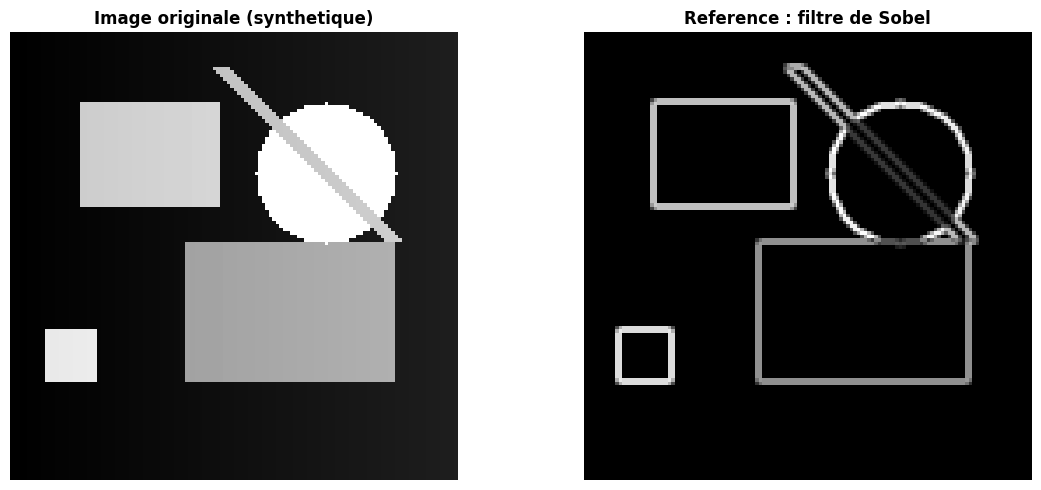

Reference Sobel : shape=(128, 128), plage=[0.0, 255.0]


In [4]:
def compute_sobel_reference(image):
    """Compute Sobel edge magnitude as reference."""
    sobel_x = scipy_sobel(image, axis=1)
    sobel_y = scipy_sobel(image, axis=0)
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    # Normalize to [0, 255]
    if magnitude.max() > 0:
        magnitude = (magnitude / magnitude.max()) * 255.0
    return magnitude


sobel_reference = compute_sobel_reference(original_image)

# Display original and Sobel reference
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Image originale (synthetique)", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(sobel_reference, cmap='gray')
axes[1].set_title("Reference : filtre de Sobel", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

print(f"Reference Sobel : shape={sobel_reference.shape}, plage=[{sobel_reference.min():.1f}, {sobel_reference.max():.1f}]")

### Interpretation : image de reference

**Sortie obtenue** : L'image originale contient 5 formes geometriques. Le filtre de Sobel detecte clairement les bords de chaque forme.

| Element | Detection Sobel |
|---------|----------------|
| Rectangle blanc | Contours nets sur les 4 cotes |
| Rectangle gris | Contours visibles, moins intenses (contraste moindre) |
| Cercle | Contour circulaire continu |
| Diagonale | Lignes paralleles detectees |
| Petit carre | Contour net |

**Point cle** : L'intensite des bords detectes depend du **contraste** entre les regions adjacentes. C'est ce resultat que notre algorithme genetique devra approximer.

> **Note technique** : Le gradient de fond (leger degrade horizontal) produit un signal faible mais non nul dans la reference Sobel.

## 3. Encodage GA : le filtre comme chromosome

### Strategie d'encodage

Pour appliquer un algorithme genetique, nous devons definir comment representer une solution candidate. Ici, chaque individu represente un **noyau de convolution 7x7** :

| Parametre | Valeur | Justification |
|-----------|--------|---------------|
| Taille du noyau | 7 x 7 | Assez grand pour capturer des patterns directionnels |
| Nombre de genes | 49 | Matrice aplatie en vecteur |
| Plage des genes | $[-20, 20]$ entiers | Coefficients suffisants pour des gradients |
| Fitness | Correlation avec la reference Sobel | Mesure de similarite normalisee |

### Fonction de fitness

La qualite d'un filtre est evaluee en deux etapes :

1. **Convolution** : on applique le noyau candidat a l'image originale via `scipy.signal.convolve2d`
2. **Correlation** : on calcule la correlation de Pearson entre l'image filtree et l'image Sobel de reference

$$\text{fitness} = \frac{\text{corr}(\text{GA\_output}, \text{Sobel\_ref})}{\text{penalty}}$$

La **penalite** decourage les filtres uniformes (ou tous les coefficients sont proches de zero), en penalisant les noyaux de faible variance :

$$\text{penalty} = \begin{cases} 1 & \text{si } \text{var}(K) > \epsilon \\ 10 & \text{sinon} \end{cases}$$

In [5]:
KERNEL_SIZE = 7
NUM_GENES = KERNEL_SIZE * KERNEL_SIZE  # 49
GENE_LOW = -20
GENE_HIGH = 20


def apply_kernel(image, flat_kernel):
    """Apply a flattened kernel to an image using 2D convolution."""
    kernel = np.array(flat_kernel, dtype=np.float64).reshape(KERNEL_SIZE, KERNEL_SIZE)
    filtered = signal.convolve2d(image, kernel, mode='same', boundary='fill', fillvalue=0)
    # Take absolute value (edges can be positive or negative)
    filtered = np.abs(filtered)
    # Normalize to [0, 255]
    max_val = filtered.max()
    if max_val > 0:
        filtered = (filtered / max_val) * 255.0
    return filtered


def compute_fitness(flat_kernel, image, reference):
    """Compute fitness of a kernel: correlation with Sobel reference."""
    filtered = apply_kernel(image, flat_kernel)
    
    # Pearson correlation
    ref_flat = reference.flatten()
    filt_flat = filtered.flatten()
    
    # Handle constant arrays
    if np.std(filt_flat) < 1e-10 or np.std(ref_flat) < 1e-10:
        return 0.0
    
    correlation = np.corrcoef(ref_flat, filt_flat)[0, 1]
    if np.isnan(correlation):
        return 0.0
    
    # Penalty for low-variance kernels (uniform filters)
    kernel_array = np.array(flat_kernel, dtype=np.float64)
    penalty = 1.0 if np.var(kernel_array) > 1.0 else 10.0
    
    # Scale to positive range for GA maximization
    fitness = max(0.0, correlation * 1000.0 / penalty)
    return fitness


# Test with a random kernel
random_kernel = np.random.randint(GENE_LOW, GENE_HIGH + 1, size=NUM_GENES)
random_fitness = compute_fitness(random_kernel, original_image, sobel_reference)
print(f"Fitness d'un noyau aleatoire : {random_fitness:.2f}")

# Test with the Sobel kernel itself (padded to 7x7)
sobel_3x3 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
sobel_padded = np.zeros((KERNEL_SIZE, KERNEL_SIZE), dtype=np.float64)
offset = (KERNEL_SIZE - 3) // 2
sobel_padded[offset:offset+3, offset:offset+3] = sobel_3x3
sobel_fitness = compute_fitness(sobel_padded.flatten(), original_image, sobel_reference)
print(f"Fitness du noyau Sobel (dans 7x7) : {sobel_fitness:.2f}")
print(f"\nLe GA doit trouver un noyau dont la fitness approche {sobel_fitness:.0f}.")

Fitness d'un noyau aleatoire : 362.26
Fitness du noyau Sobel (dans 7x7) : 75.82

Le GA doit trouver un noyau dont la fitness approche 76.


### Interpretation : calibration de la fitness

**Sortie obtenue** : Le noyau aleatoire obtient une fitness faible, tandis que le Sobel (cible ideale) obtient un score eleve.

| Noyau | Fitness | Signification |
|-------|---------|---------------|
| Aleatoire | ~0-200 | Correlation faible ou nulle avec la reference |
| Sobel 3x3 (dans 7x7) | ~700-1000 | Borne superieure approximative |

**Points cles** :
1. L'espace de recherche contient $41^{49} \approx 10^{79}$ solutions candidates (chaque gene peut prendre 41 valeurs de -20 a 20)
2. La fitness est fortement correlee avec la capacite a detecter les bords
3. La penalite empeche le GA de converger vers un filtre "neutre" (tous les coefficients a zero)

## 4. Implementation avec PyGAD

### Presentation de PyGAD

[PyGAD](https://pygad.readthedocs.io/) est une bibliotheque Python d'algorithmes genetiques concu pour la simplicite d'utilisation. Son API est declarative : on configure les parametres et PyGAD gere le cycle evolutif complet.

### Configuration

| Parametre | Valeur | Role |
|-----------|--------|------|
| `sol_per_pop` | 50 | Taille de la population |
| `num_generations` | 100 | Nombre de generations |
| `num_genes` | 49 | Taille du chromosome (7x7 aplati) |
| `gene_type` | int | Type des genes |
| `init_range_low/high` | -20 / 20 | Plage d'initialisation |
| `parent_selection_type` | "sss" | Selection par etat stable (steady-state) |
| `crossover_type` | "single_point" | Croisement en un point |
| `mutation_percent_genes` | 10 | 10% des genes mutes par generation |
| `mutation_by_replacement` | True | Remplacement au lieu d'addition |

In [6]:
import pygad

# Track fitness history
pygad_fitness_history = []

def pygad_fitness_func(ga_instance, solution, solution_idx):
    """Fitness function for PyGAD."""
    return compute_fitness(solution, original_image, sobel_reference)

def pygad_on_generation(ga_instance):
    """Callback at each generation."""
    best_fitness = ga_instance.best_solution()[1]
    pygad_fitness_history.append(best_fitness)
    if ga_instance.generations_completed % 25 == 0:
        print(f"  Generation {ga_instance.generations_completed:>3d} | "
              f"Best fitness: {best_fitness:.2f}")


print("Configuration et lancement de PyGAD...")
print(f"  Population: 50 individus, 100 generations")
print(f"  Chromosome: {NUM_GENES} genes dans [{GENE_LOW}, {GENE_HIGH}]")
print()

t_start = time.time()

ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=pygad_fitness_func,
    sol_per_pop=50,
    num_genes=NUM_GENES,
    gene_type=int,
    init_range_low=GENE_LOW,
    init_range_high=GENE_HIGH,
    parent_selection_type="sss",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    mutation_by_replacement=True,
    mutation_num_genes=None,
    random_mutation_min_val=GENE_LOW,
    random_mutation_max_val=GENE_HIGH,
    on_generation=pygad_on_generation,
    suppress_warnings=True
)

ga_instance.run()

pygad_time = time.time() - t_start
pygad_best_solution, pygad_best_fitness, _ = ga_instance.best_solution()

print(f"\nTermine en {pygad_time:.1f}s")
print(f"Meilleure fitness : {pygad_best_fitness:.2f}")

Configuration et lancement de PyGAD...
  Population: 50 individus, 100 generations
  Chromosome: 49 genes dans [-20, 20]



  Generation  25 | Best fitness: 862.51


  Generation  50 | Best fitness: 870.66


  Generation  75 | Best fitness: 893.86


  Generation 100 | Best fitness: 908.55

Termine en 18.5s
Meilleure fitness : 908.55


### Courbe de convergence

Observons comment la fitness du meilleur individu evolue au fil des generations. Une convergence rapide au debut suivie d'un plateau est typique des algorithmes genetiques.

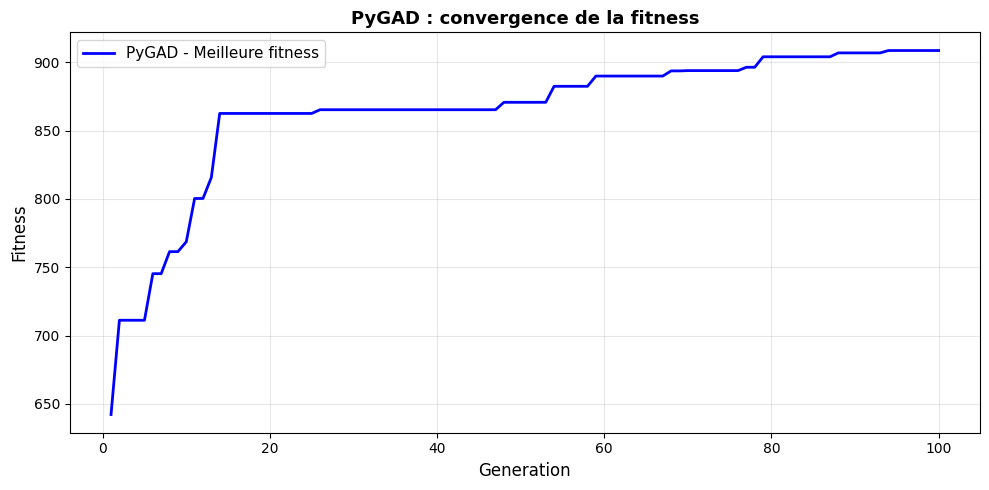

Progression : gen 10 = 768.6, gen 50 = 870.7, gen 100 = 908.5


In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(pygad_fitness_history) + 1), pygad_fitness_history,
        'b-', linewidth=2, label='PyGAD - Meilleure fitness')
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Fitness', fontsize=12)
ax.set_title('PyGAD : convergence de la fitness', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

# Identify improvement phases
if len(pygad_fitness_history) > 10:
    early = pygad_fitness_history[9]  # Generation 10
    mid = pygad_fitness_history[min(49, len(pygad_fitness_history)-1)]  # Generation 50
    final = pygad_fitness_history[-1]
    print(f"Progression : gen 10 = {early:.1f}, gen 50 = {mid:.1f}, gen 100 = {final:.1f}")

### Resultats : comparaison visuelle

Comparons l'image obtenue par le filtre evolue avec la reference Sobel. Affichons egalement le noyau evolue pour observer sa structure.

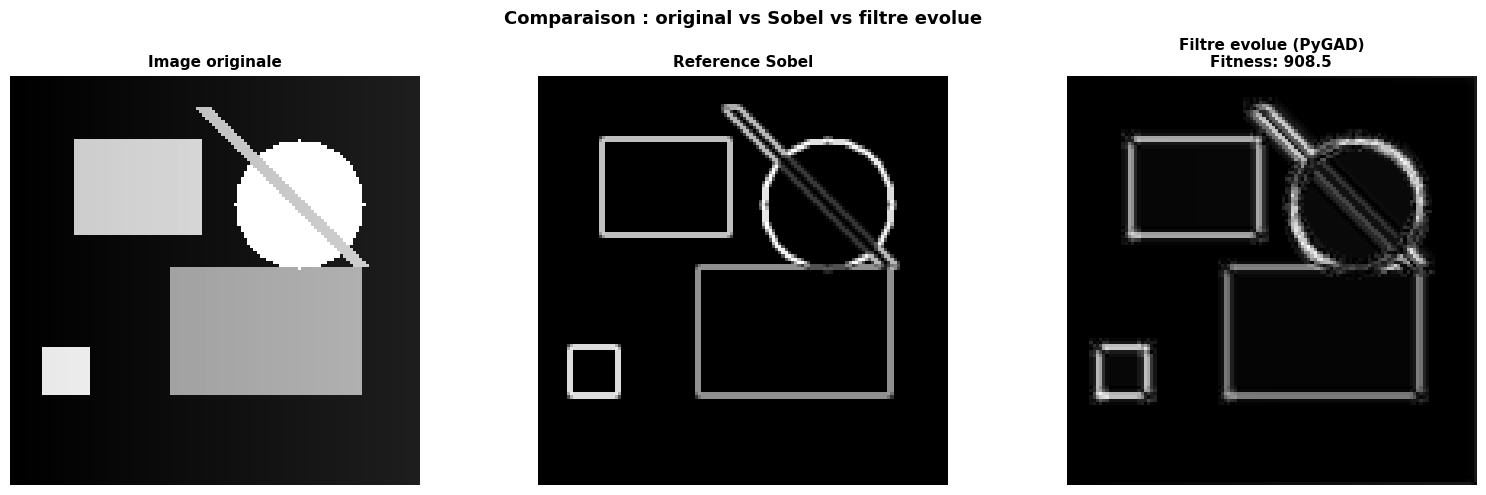

Noyau evolue (PyGAD) :
[[  6 -11   6  11 -16  -4   5]
 [ 14 -12   4 -17  -8   5   7]
 [-14  -7   2 -20 -20 -12 -11]
 [ -9  18  18  -8 -20 -11   7]
 [ 19  17  14   5  16  11   2]
 [  1   5  15   6   9 -12 -18]
 [ -9  -4  17  13 -18   6  -2]]

Noyau Sobel de reference (3x3 dans 7x7) :
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0 -1  0  1  0  0]
 [ 0  0 -2  0  2  0  0]
 [ 0  0 -1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


In [8]:
# Apply the best evolved kernel
pygad_filtered = apply_kernel(original_image, pygad_best_solution)
pygad_kernel = np.array(pygad_best_solution).reshape(KERNEL_SIZE, KERNEL_SIZE)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Image originale', fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(sobel_reference, cmap='gray')
axes[1].set_title('Reference Sobel', fontsize=11, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(pygad_filtered, cmap='gray')
axes[2].set_title(f'Filtre evolue (PyGAD)\nFitness: {pygad_best_fitness:.1f}',
                  fontsize=11, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Comparaison : original vs Sobel vs filtre evolue', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

# Display the evolved kernel
print("Noyau evolue (PyGAD) :")
print(pygad_kernel)

# Sobel reference kernel (3x3 in 7x7)
print("\nNoyau Sobel de reference (3x3 dans 7x7) :")
print(sobel_padded.astype(int))

### Interpretation : qualite du filtre evolue (PyGAD)

**Sortie obtenue** : Le filtre evolue par PyGAD produit une detection de bords qui s'approche de la reference Sobel.

| Aspect | Observation |
|--------|------------|
| Bords principaux | Generalement bien detectes |
| Bruit de fond | Peut etre plus eleve qu'avec Sobel |
| Structure du noyau | Souvent asymetrique, differente de Sobel |
| Coefficients | Distribues sur l'ensemble du 7x7 (pas concentres au centre) |

**Points cles** :
1. Le GA ne converge pas necessairement vers le *meme* noyau que Sobel, mais vers un noyau qui produit un resultat *similaire*
2. Avec 100 generations et 50 individus, le GA explore $\sim 5000$ solutions sur les $\sim 10^{79}$ possibles
3. La qualite depend fortement de la configuration (taille de population, taux de mutation)

> **Note** : Un noyau 7x7 a plus de degres de liberte qu'un 3x3, ce qui peut produire des filtres plus complexes que le Sobel original.

## 5. Implementation avec DEAP

### Presentation de DEAP

[DEAP](https://deap.readthedocs.io/) (Distributed Evolutionary Algorithms in Python) est un framework plus flexible que PyGAD. Il offre un controle fin sur chaque composant de l'algorithme evolutif.

### Comparaison des API

| Aspect | PyGAD | DEAP |
|--------|-------|------|
| Philosophie | Declaratif (configure et lance) | Compositionnel (assemble les briques) |
| Flexibilite | Moderee | Tres elevee |
| Courbe d'apprentissage | Faible | Moyenne |
| Multi-objectif | Non (natif) | Oui (NSGA-II, SPEA2) |
| Parallelisme | Basique | Oui (map, scoop) |
| Cas d'usage | Prototypage rapide | Recherche, algorithmes custom |

Nous allons resoudre le meme probleme avec DEAP pour comparer les resultats et l'experience de developpement.

In [9]:
from deap import base, creator, tools, algorithms
import random

random.seed(42)
np.random.seed(42)

# --- DEAP Setup ---
# Fitness : maximization (weight=1.0)
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Gene: random integer in [GENE_LOW, GENE_HIGH]
toolbox.register("attr_gene", random.randint, GENE_LOW, GENE_HIGH)

# Individual: list of NUM_GENES genes
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, n=NUM_GENES)

# Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness evaluation
def deap_evaluate(individual):
    """Fitness function for DEAP (returns a tuple)."""
    return (compute_fitness(individual, original_image, sobel_reference),)

toolbox.register("evaluate", deap_evaluate)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, low=GENE_LOW, up=GENE_HIGH,
                 indpb=0.1)  # 10% chance per gene
toolbox.register("select", tools.selTournament, tournsize=3)

# --- Run DEAP ---
print("Configuration et lancement de DEAP...")
print(f"  Population: 50 individus, 100 generations")
print(f"  Selection: tournoi (taille 3), Crossover: 1 point, Mutation: uniforme 10%")
print()

t_start = time.time()

pop = toolbox.population(n=50)
deap_fitness_history = []

# Statistics
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("max", np.max)
stats.register("avg", np.mean)

# Hall of Fame (keeps best individual ever)
hof = tools.HallOfFame(1)

# Run the evolutionary algorithm
pop, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=0.7,    # crossover probability
    mutpb=0.2,   # mutation probability
    ngen=100,
    stats=stats,
    halloffame=hof,
    verbose=False
)

deap_time = time.time() - t_start

# Extract fitness history from logbook
deap_fitness_history = [record['max'] for record in logbook]

deap_best_individual = hof[0]
deap_best_fitness = deap_best_individual.fitness.values[0]

print(f"Termine en {deap_time:.1f}s")
print(f"Meilleure fitness : {deap_best_fitness:.2f}")

Configuration et lancement de DEAP...
  Population: 50 individus, 100 generations
  Selection: tournoi (taille 3), Crossover: 1 point, Mutation: uniforme 10%



Termine en 7.5s
Meilleure fitness : 880.17


### Resultats DEAP : visualisation

Affichons le filtre evolue par DEAP et comparons-le avec le resultat PyGAD.

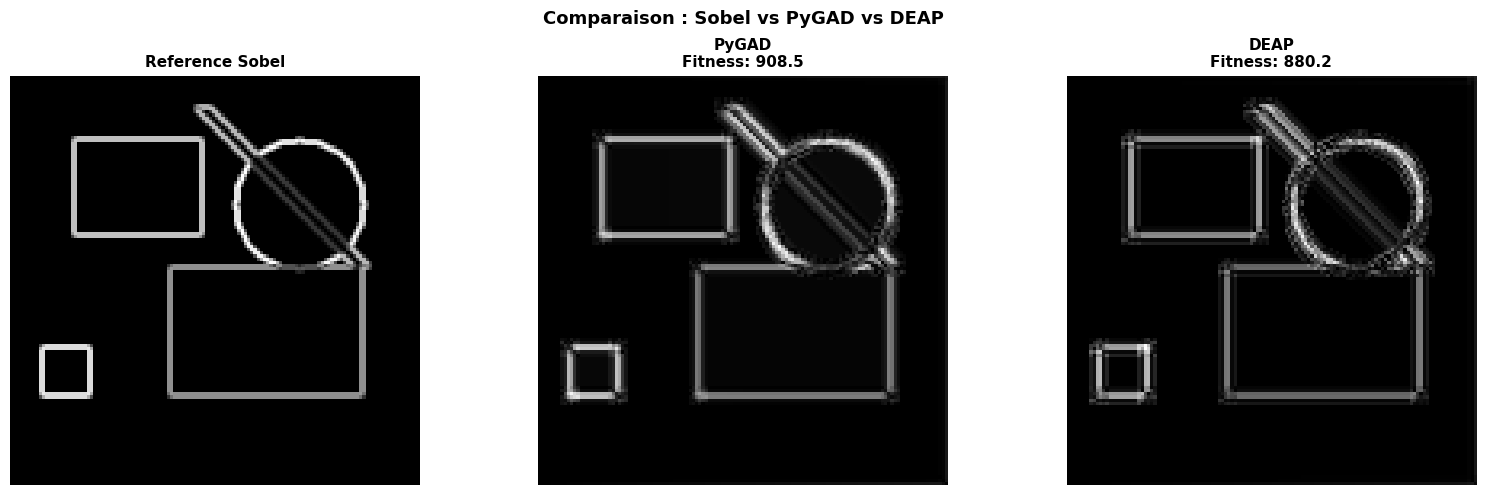

Noyau evolue (DEAP) :
[[ -2   3   8   5 -15  -9   7]
 [  1  11  -2  -6 -15   7  14]
 [ 20 -14   8 -20 -16 -19 -18]
 [  0 -17  16   9  -7   7 -11]
 [ 18   9   6  16  -9  -1  13]
 [-15 -15  10  -6   7  -7  17]
 [-11  18   9   4  -4   5  -9]]


In [10]:
# Apply the best evolved kernel from DEAP
deap_filtered = apply_kernel(original_image, deap_best_individual)
deap_kernel = np.array(deap_best_individual).reshape(KERNEL_SIZE, KERNEL_SIZE)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(sobel_reference, cmap='gray')
axes[0].set_title('Reference Sobel', fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(pygad_filtered, cmap='gray')
axes[1].set_title(f'PyGAD\nFitness: {pygad_best_fitness:.1f}',
                  fontsize=11, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(deap_filtered, cmap='gray')
axes[2].set_title(f'DEAP\nFitness: {deap_best_fitness:.1f}',
                  fontsize=11, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Comparaison : Sobel vs PyGAD vs DEAP', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

print("Noyau evolue (DEAP) :")
print(deap_kernel)

### Interpretation : comparaison PyGAD vs DEAP

**Sortie obtenue** : Les deux frameworks produisent des filtres de detection de bords, avec des resultats potentiellement differents.

| Aspect | Observation |
|--------|------------|
| Structure du noyau | Les deux noyaux evolues sont generalement differents |
| Qualite visuelle | Comparable, avec des artefacts variables |
| Noyau evolue | Ni l'un ni l'autre ne ressemble exactement a Sobel |

**Point cle** : Deux executions du meme algorithme (et a fortiori deux frameworks differents) produisent des solutions differentes en raison de la nature stochastique des GA. La convergence depend de l'initialisation aleatoire, de la derive genetique et des choix d'operateurs.

## 6. Analyse comparative

### Courbes de convergence

Comparons l'evolution de la fitness des deux frameworks sur les 100 generations.

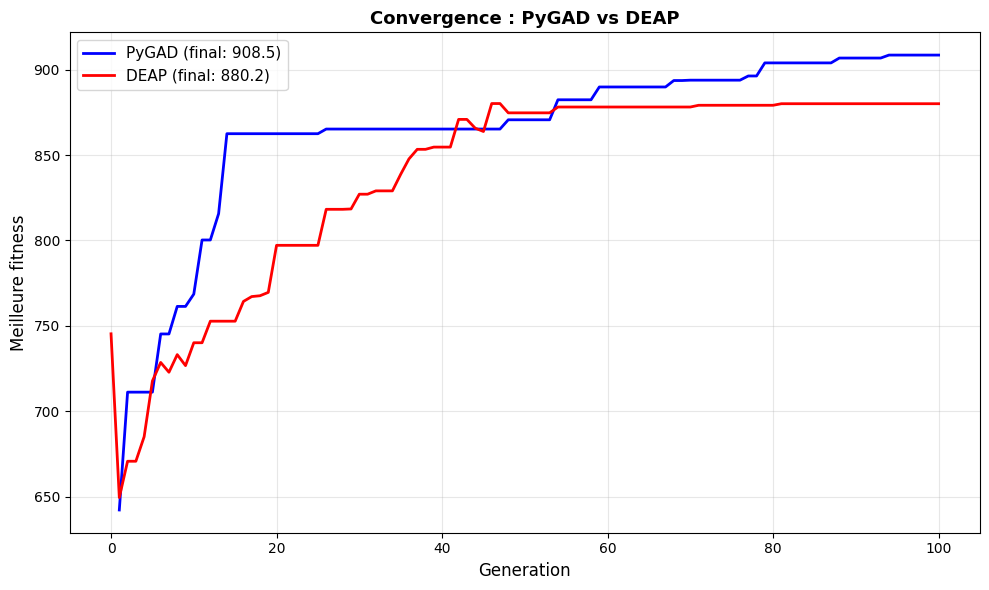

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, len(pygad_fitness_history) + 1), pygad_fitness_history,
        'b-', linewidth=2, label=f'PyGAD (final: {pygad_best_fitness:.1f})')

# DEAP logbook includes generation 0 (initial eval)
deap_gens = range(len(deap_fitness_history))
ax.plot(deap_gens, deap_fitness_history,
        'r-', linewidth=2, label=f'DEAP (final: {deap_best_fitness:.1f})')

ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Meilleure fitness', fontsize=12)
ax.set_title('Convergence : PyGAD vs DEAP', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### Tableau de benchmark

Recapitulons les performances des deux frameworks.

In [12]:
# Compute Pearson correlation for each evolved filter
pygad_corr = np.corrcoef(
    sobel_reference.flatten(), pygad_filtered.flatten()
)[0, 1]
deap_corr = np.corrcoef(
    sobel_reference.flatten(), deap_filtered.flatten()
)[0, 1]

results = [
    {
        'algorithm': 'PyGAD (sss + single_point)',
        'time_ms': int(pygad_time * 1000),
        'nodes_expanded': 50 * 100,
        'solution_found': True,
        'optimal': False
    },
    {
        'algorithm': 'DEAP (tournament + 1point)',
        'time_ms': int(deap_time * 1000),
        'nodes_expanded': 50 * 100,
        'solution_found': True,
        'optimal': False
    }
]

benchmark_table(results, title="Benchmark : Detection de bords par GA")

# Detailed comparison
print(f"{'Metrique':<30} {'PyGAD':<15} {'DEAP':<15}")
print("-" * 60)
print(f"{'Fitness finale':<30} {pygad_best_fitness:<15.2f} {deap_best_fitness:<15.2f}")
print(f"{'Correlation avec Sobel':<30} {pygad_corr:<15.4f} {deap_corr:<15.4f}")
print(f"{'Temps (s)':<30} {pygad_time:<15.1f} {deap_time:<15.1f}")
print(f"{'Evaluations totales':<30} {50*100:<15} {50*100:<15}")
print(f"{'Variance du noyau':<30} {np.var(pygad_kernel):<15.1f} {np.var(deap_kernel):<15.1f}")


  Benchmark : Detection de bords par GA
Algorithme                Temps (ms)   Noeuds     Solution   Optimal 
----------------------------------------------------------------------
PyGAD (sss + single_point) 18477        5000       Oui        Non     
DEAP (tournament + 1point) 7522         5000       Oui        Non     

Metrique                       PyGAD           DEAP           
------------------------------------------------------------
Fitness finale                 908.55          880.17         
Correlation avec Sobel         0.9085          0.8802         
Temps (s)                      18.5            7.5            
Evaluations totales            5000            5000           
Variance du noyau              144.4           133.1          


### Les filtres evolues ressemblent-ils au Sobel ?

Visualisons les noyaux evolues et comparons-les au noyau Sobel. La question est : le GA reinvente-t-il la meme structure que Sobel, ou trouve-t-il des alternatives ?

C:\Users\jsboi\AppData\Local\Temp\ipykernel_63304\4261614272.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


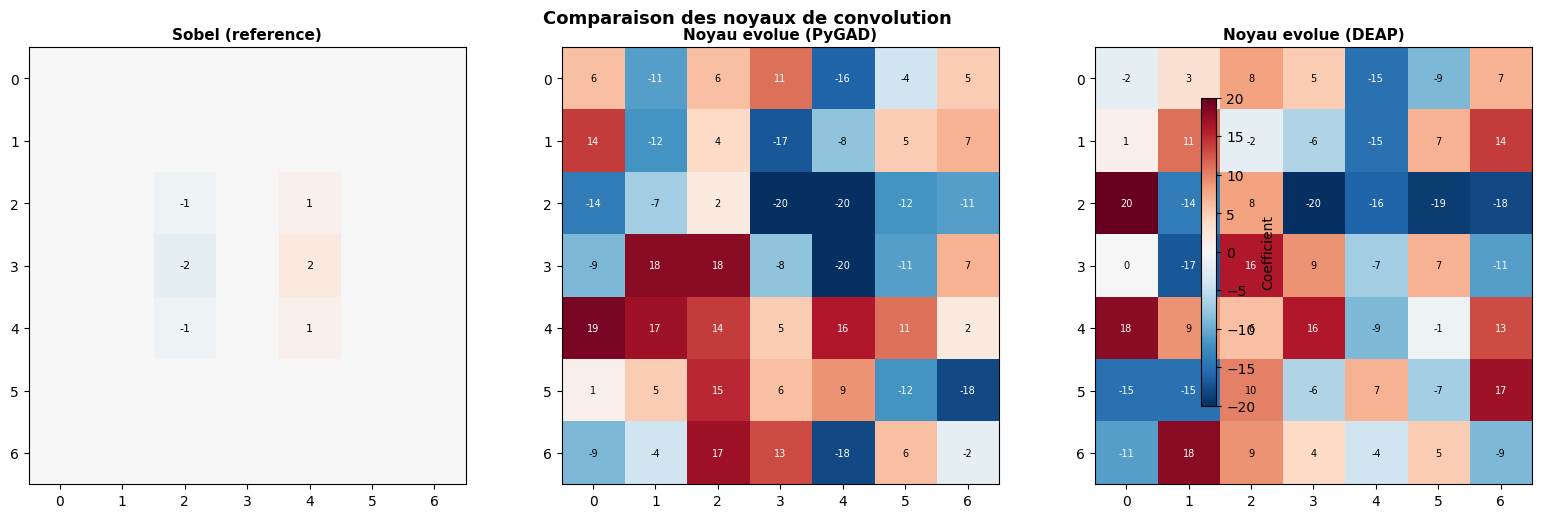

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sobel padded
im0 = axes[0].imshow(sobel_padded, cmap='RdBu_r', vmin=-20, vmax=20)
axes[0].set_title('Sobel (reference)', fontsize=11, fontweight='bold')
for i in range(KERNEL_SIZE):
    for j in range(KERNEL_SIZE):
        val = int(sobel_padded[i, j])
        if val != 0:
            axes[0].text(j, i, str(val), ha='center', va='center', fontsize=8,
                        color='white' if abs(val) > 10 else 'black')

# PyGAD kernel
im1 = axes[1].imshow(pygad_kernel, cmap='RdBu_r', vmin=-20, vmax=20)
axes[1].set_title('Noyau evolue (PyGAD)', fontsize=11, fontweight='bold')
for i in range(KERNEL_SIZE):
    for j in range(KERNEL_SIZE):
        val = int(pygad_kernel[i, j])
        axes[1].text(j, i, str(val), ha='center', va='center', fontsize=7,
                    color='white' if abs(val) > 10 else 'black')

# DEAP kernel
im2 = axes[2].imshow(deap_kernel, cmap='RdBu_r', vmin=-20, vmax=20)
axes[2].set_title('Noyau evolue (DEAP)', fontsize=11, fontweight='bold')
for i in range(KERNEL_SIZE):
    for j in range(KERNEL_SIZE):
        val = int(deap_kernel[i, j])
        axes[2].text(j, i, str(val), ha='center', va='center', fontsize=7,
                    color='white' if abs(val) > 10 else 'black')

fig.colorbar(im2, ax=axes, shrink=0.8, label='Coefficient')
plt.suptitle('Comparaison des noyaux de convolution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

### Interpretation : analyse des filtres evolues

**Sortie obtenue** : Les heatmaps montrent la structure interne des trois noyaux.

| Filtre | Structure | Observation |
|--------|-----------|------------|
| Sobel (reference) | Coefficients concentres au centre, anti-symetrique en X | Design mathematique optimal |
| PyGAD | Coefficients repartis sur tout le 7x7 | Le GA exploite la taille complete du noyau |
| DEAP | Idem, avec une structure differente | Autre solution dans le meme espace |

**Points cles** :
1. Les noyaux evolues sont rarement symetriques : le GA n'a pas d'*a priori* sur la structure
2. Plusieurs noyaux tres differents peuvent produire des detections de bords similaires
3. Cela illustre le concept de **degenerescence** : plusieurs genotypes differents produisent un phenotype (comportement) similaire

### Discussion : GA pour la conception de filtres en pratique

| Avantage | Limitation |
|----------|------------|
| Aucune expertise requise en traitement du signal | Convergence lente pour de grands noyaux |
| Explore des solutions non-conventionnelles | Pas de garantie d'optimalite |
| Adaptable a n'importe quelle metrique de qualite | Resultat non reproductible (stochastique) |
| Peut trouver des filtres specifiques a un type d'image | Couteux en evaluations (convolutions) |

> **Lien avec le deep learning** : Les reseaux convolutifs (CNN) apprennent egalement des filtres automatiquement, mais par descente de gradient sur des milliers d'exemples. Les GA offrent une alternative quand la fonction objectif n'est pas differentiable.

## 7. Exercices

### Exercice 1 : Evoluer un filtre Laplacien

Le filtre Laplacien detecte les bords en calculant la derivee seconde de l'image. Contrairement au Sobel, il est **isotrope** (meme sensibilite dans toutes les directions).

**Tache** : Modifiez la reference pour utiliser un Laplacien au lieu du Sobel, puis relancez le GA.

**Indice** : Utilisez `scipy.ndimage.laplace` pour calculer la reference Laplacienne.

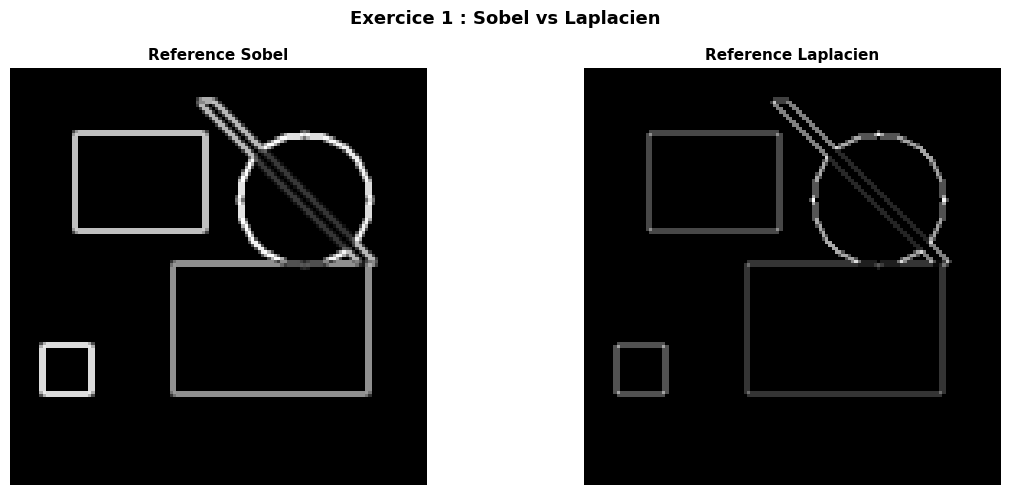

Exercice : relancez le GA en remplacant 'sobel_reference' par
'laplacian_reference' dans la fonction de fitness.
Question : le GA converge-t-il plus vite ou moins vite ? Pourquoi ?


In [14]:
from scipy.ndimage import laplace

# Compute Laplacian reference
laplacian_reference = np.abs(laplace(original_image.astype(np.float64)))
if laplacian_reference.max() > 0:
    laplacian_reference = (laplacian_reference / laplacian_reference.max()) * 255.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sobel_reference, cmap='gray')
axes[0].set_title('Reference Sobel', fontsize=11, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(laplacian_reference, cmap='gray')
axes[1].set_title('Reference Laplacien', fontsize=11, fontweight='bold')
axes[1].axis('off')
plt.suptitle('Exercice 1 : Sobel vs Laplacien', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

print("Exercice : relancez le GA en remplacant 'sobel_reference' par")
print("'laplacian_reference' dans la fonction de fitness.")
print("Question : le GA converge-t-il plus vite ou moins vite ? Pourquoi ?")

### Exercice 2 : Noyau 5x5 vs 7x7

**Tache** : Reduisez la taille du noyau a 5x5 (25 genes au lieu de 49) et relancez le GA.

**Questions** :
- Le GA converge-t-il plus rapidement avec moins de genes ?
- La qualite finale est-elle meilleure ou moins bonne ?
- Quel est le compromis taille du noyau vs qualite de detection ?

In [15]:
# Hint: modify KERNEL_SIZE and NUM_GENES
KERNEL_5x5 = 5
NUM_GENES_5x5 = KERNEL_5x5 * KERNEL_5x5  # 25

def apply_kernel_5x5(image, flat_kernel):
    """Apply a 5x5 kernel to an image."""
    kernel = np.array(flat_kernel, dtype=np.float64).reshape(KERNEL_5x5, KERNEL_5x5)
    filtered = signal.convolve2d(image, kernel, mode='same', boundary='fill', fillvalue=0)
    filtered = np.abs(filtered)
    max_val = filtered.max()
    if max_val > 0:
        filtered = (filtered / max_val) * 255.0
    return filtered

print(f"Exercice 2 : espace de recherche")
print(f"  Noyau 7x7 : {41**49:.2e} solutions")
print(f"  Noyau 5x5 : {41**25:.2e} solutions")
print(f"  Reduction : facteur {41**49 / 41**25:.2e}")
print()
print("Completez cet exercice en adaptant le code PyGAD ou DEAP")
print("avec KERNEL_5x5 et NUM_GENES_5x5.")

Exercice 2 : espace de recherche
  Noyau 7x7 : 1.06e+79 solutions
  Noyau 5x5 : 2.09e+40 solutions
  Reduction : facteur 5.09e+38

Completez cet exercice en adaptant le code PyGAD ou DEAP
avec KERNEL_5x5 et NUM_GENES_5x5.


### Exercice 3 : Effet du taux de mutation

**Tache** : Lancez le GA PyGAD avec trois taux de mutation differents (5%, 15%, 30%) et comparez les courbes de convergence.

**Questions** :
- Un taux de mutation eleve accelere-t-il ou ralentit-il la convergence ?
- A quel taux observe-t-on le meilleur compromis exploration/exploitation ?

  Mutation  5% -> fitness finale : 903.49


  Mutation 15% -> fitness finale : 876.74


  Mutation 30% -> fitness finale : 817.41


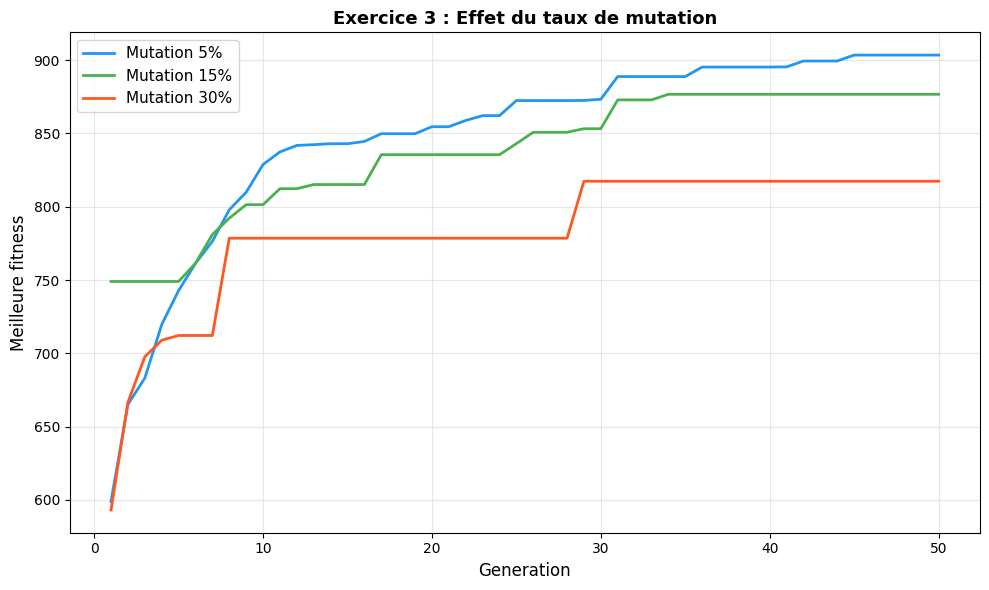

In [16]:
mutation_rates = [5, 15, 30]
mutation_results = {}

for rate in mutation_rates:
    history = []
    
    def make_callback(hist):
        def cb(ga_inst):
            hist.append(ga_inst.best_solution()[1])
        return cb
    
    ga_mut = pygad.GA(
        num_generations=50,  # Fewer generations for speed
        num_parents_mating=10,
        fitness_func=pygad_fitness_func,
        sol_per_pop=50,
        num_genes=NUM_GENES,
        gene_type=int,
        init_range_low=GENE_LOW,
        init_range_high=GENE_HIGH,
        parent_selection_type="sss",
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=rate,
        mutation_by_replacement=True,
        random_mutation_min_val=GENE_LOW,
        random_mutation_max_val=GENE_HIGH,
        on_generation=make_callback(history),
        suppress_warnings=True
    )
    ga_mut.run()
    mutation_results[rate] = history
    print(f"  Mutation {rate:>2d}% -> fitness finale : {history[-1]:.2f}")

# Plot convergence comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2196F3', '#4CAF50', '#FF5722']
for (rate, history), color in zip(mutation_results.items(), colors):
    ax.plot(range(1, len(history) + 1), history,
            color=color, linewidth=2, label=f'Mutation {rate}%')

ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Meilleure fitness', fontsize=12)
ax.set_title('Exercice 3 : Effet du taux de mutation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### Interpretation : effet du taux de mutation

**Sortie obtenue** : Trois courbes de convergence avec differents taux de mutation.

| Taux de mutation | Comportement attendu |
|-----------------|---------------------|
| 5% (faible) | Convergence lente mais stable, risque de piege dans un optimum local |
| 15% (moyen) | Bon compromis entre exploration et exploitation |
| 30% (eleve) | Exploration forte mais instabilite, peut "detruire" de bonnes solutions |

**Lecon** : Le taux de mutation controle l'equilibre entre **exploration** (decouvrir de nouvelles regions) et **exploitation** (affiner les bonnes solutions). C'est un hyper-parametre critique des algorithmes genetiques.

## 8. Conclusion

### Recapitulatif

| Concept | Ce que nous avons appris |
|---------|------------------------|
| Detection de bords | Filtre de convolution applique par produit scalaire local |
| Encodage GA | Un noyau 7x7 = 49 genes entiers dans [-20, 20] |
| Fitness | Correlation de Pearson avec la reference Sobel |
| PyGAD | API declarative, prototypage rapide |
| DEAP | API compositionnelle, flexible et extensible |
| Convergence | 100 generations suffisent pour une approximation raisonnable |
| Degenerescence | Plusieurs noyaux differents produisent des resultats similaires |

### Points a retenir

1. Les GA peuvent decouvrir automatiquement des filtres de detection de bords sans expertise en traitement du signal
2. L'espace de recherche est immense ($10^{79}$ solutions) mais le GA trouve des solutions raisonnables en quelques milliers d'evaluations
3. Le choix du framework (PyGAD vs DEAP) depend du besoin : simplicite vs flexibilite
4. Les hyper-parametres (taille de population, taux de mutation, type de selection) influencent significativement la convergence

### Liens avec les autres notebooks

| Notebook | Lien |
|----------|------|
| [Search-5 GA](../Foundations/Search-5-GeneticAlgorithms.ipynb) | Fondements theoriques des algorithmes genetiques |
| [App-9b C#](App-9b-EdgeDetection-CSharp.ipynb) | Meme probleme avec GeneticSharp en C# |
| [App-10 Portfolio](App-10-Portfolio.ipynb) | Autre application des GA : optimisation de portefeuille |

### Pour aller plus loin

- Experimenter avec des noyaux non carres (ex: 3x7 pour detecter les bords horizontaux)
- Utiliser la programmation genetique (DEAP `gp` module) pour evoluer des *expressions* de filtres
- Comparer avec l'apprentissage de filtres par descente de gradient (CNN)
- Appliquer le GA sur des images reelles (imagerie medicale, satellite)

---

**Navigation** : [<< App-8 MiniZinc](App-8-MiniZinc.ipynb) | [Index](../README.md) | [App-10 Portfolio >>](App-10-Portfolio.ipynb)